# Speech Enhancement and Evaluations

- implement basic speech enhancement techniques, evaluate and visualize the quality of the enhancement

- implement four different filtering methods: **Spectral-subtraction**, **Wiener-filter**, **linear filter** and a **VAD based filter**.

In all these filters, two things are used: 

1. a constant average magnitude noise model 

2. an ideal noise estimate which is the true noise you generate to create the noisy signal. 

The enhanced signals are evaluated by computing the signal-to-noise ratios-global SNR and segmental SNR. 

To visualize the results, the segmental SNRs of all enhanced signals are plotted.

Besides this, the spectrograms of the clean, noisy and the three enhanced results are plotted and visually inspected.

Following functions are implemented

1. `noiseEst`: Estimate the noise for the noisy signal based on ideal and average noise models.

2. `spectralSub`: Enhance the noisy signal by spectral subtraction.

3. `wiener`:  Enhance the noisy signal by Wiener filter.

4. `linear`: Enhance the noisy signal by linear filter.

5. `vadEnhance`: Enhance the noisy signal by VAD based filter.

6. `snrGlb`: Compute the global SNR of the enhanced signals

7. `snrSeg`: Compute the frame-wise segmental SNR of the enhanced signals.


## Steps

- Generate a noisy signal (additive white Gaussian noise of power -35dB)

- Estimate the noise for the noisy signal, based on 
	1. ideal estimate 
	
	2. avg noise model, by completing "noiseEst". 
	
    (Note that this function should return estimates of the same dimension as the input noise matrix.)

- Enhance the noisy signal by implementing the filtering functions 
    1) Spectral subtraction: "spectralSub", 
	
	2) Wiener filter: "wiener", 
	
	3) Linear filter: "linear", 
    
	4) VAD based filter: "vadEnhance"

- Compute the global SNR and the frame-wise segmental SNR of the enhanced signals by computing
 	1. snrGlb 
 	
	2. snrSeg
 
- Plot and visualize the results.

In [1]:
from utils import *

## prepare the speech signal

In [2]:
# # Read the audio file and sampling rate
# Fs_target = 16000
# Fs,data_clean = wav.read('hello.wav')
# data_clean = data_clean[:, 0]

# # Transform signal from int16 (-32768 to 32767) to float32 (-1,1)
# if type(data_clean[0]) == np.int16:
#     data_clean = np.divide(data_clean,32768,dtype=np.float32)

# # Make sure the sampling rate is 16kHz
# if not (Fs == Fs_target):
#     data_clean = sig.resample_poly(data_clean,Fs_target,Fs)
#     Fs = Fs_target

In [3]:
data_clean, Fs = loading('hello.wav', 16000)

## windowing

In [4]:
# Split the data sequence into windows.
frame_length_ms = 25 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 25ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms (25/2 ms) in samples (50% overlap)

In [5]:
frame_matrix_clean = windowing(data_clean, frame_length, hop_size, 'hamming')

In [6]:
frame_matrix_clean.shape

(400, 311)

## functions

In [7]:
def WGN(data_len, snr):
    #Add white gaussian noise to the signal with the defined snr.

    noise = np.random.normal(0,1,data_len)
    pow_ratio = np.power(10,(snr/20))
    noise_red = noise*pow_ratio

    return noise_red

In [8]:
def read_targets():
    #Target files must be in the same directory
    with open('ground_truth','r') as f:
        data = f.read()
    
    targets = np.array([int(i) for i in data.split()])
    targets = targets.reshape((1,len(targets)))
    return targets

In [9]:
def getWindow(frame_length,windowing_type):
    if (windowing_type == 'rect'):
        window = np.ones(frame_length)
    elif (windowing_type == 'hann'):
        window = np.hanning(frame_length)
    elif (windowing_type == 'cosine'):
        window = np.sqrt(np.hanning(frame_length))
    elif (windowing_type == 'hamming'):
        window = np.hamming(frame_length)
    else:
        print('Windowing function not supported')
        exit()
    return window.reshape(-1,1)

## add noise to the clean data

In [10]:
# Generate a noisy signal

# Generate white Gaussian noise of strength -35dB 
noise = WGN(data_clean.shape[0], -35)
# Generate the noisy signal, where the noise is additive white Guassian
data_noisy = data_clean + noise

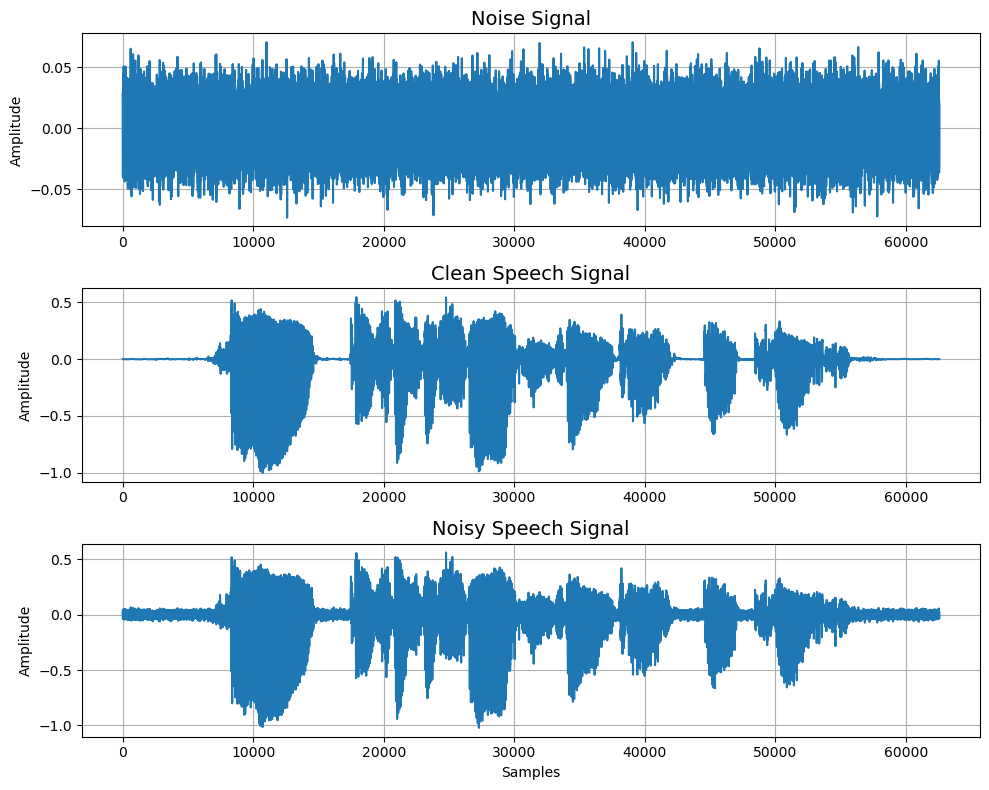

In [11]:
plt.figure(figsize=(10, 8))

# First subplot: Noise signal with a soft red color
plt.subplot(3, 1, 1)
plt.plot(noise)
plt.title('Noise Signal', fontsize=14)
plt.ylabel('Amplitude')
plt.grid(True)

# Second subplot: Clean speech signal with a soft blue color
plt.subplot(3, 1, 2)
plt.plot(data_clean)
plt.title('Clean Speech Signal', fontsize=14)
plt.ylabel('Amplitude')
plt.grid(True)

# Third subplot: Noisy signal with a soft green color
plt.subplot(3, 1, 3)
plt.plot(data_noisy)
plt.title('Noisy Speech Signal', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)

# Adjust layout so subplots do not overlap
plt.tight_layout()

# Display the plot
plt.show()

## Noise estimation

In [20]:
def noiseEst(data_matrix,est_type):
    # If estimation type is ideal noise, return back the true noise value. 
    # If estimation type is avg_noise_model, get the average noise model by computing the mean of the noise type. 
    # The dimesions of 'noise_estimation' should be same as the dimensions of the input data_matrix
    if (est_type == 'avg_noise_model'):
        noise_mat = data_matrix
        noise_freq = np.fft.fft(noise_mat, axis=0)
        #Get the average-noise model
        avg_noise = np.mean(np.power(np.absolute(noise_freq), 2), axis=1)
        # Return model of the same dimensions as input noise matrix
        noise_estimation = np.tile(avg_noise.reshape((-1, 1)), (1,data_matrix.shape[1]))
    elif (est_type == 'ideal_noise'):
        #Get the ideal noise
        noise_mat = data_matrix
        noise_freq = np.fft.fft(noise_mat, axis=0)
        noise_estimation = np.square(np.abs(noise_freq))
    else:
        print('Wrong noise type')
        exit()
    
    return noise_estimation

## Filtering

### Spectral subtraction

Conventional spectral subtraction is defined such that we subtract the estimated noise energy $|\hat V(f)|^2$
from the energy of the observation $|X(f,k)|^2$. We do not have an estimate of the phase, whereby we do not
modify the signal phase. The energy of the estimated clean signal is then
\begin{equation}
  |\hat S(f,k)|^2 =
  \begin{cases}
    |X(f,k)|^2 - |V(f)|^2, &\text{when~} |X(f,k)|^2 > |V(f)|^2\\
    0,&\text{otherwise.}
  \end{cases}
\end{equation}
Above we used a threshold $|X(f,k)|^2 > |V(f)|^2$, because otherwise the estimated signal
energy would be negative. Since negative energy is physically impossible, we put the estimate to
zero always when that would occur.

Furthermore, we want to keep the phase of the original signal, whereby
\begin{equation}
  \angle \hat S(f,k) = \angle X(f,k) = \frac{X(f,k)}{|X(f,k)|}.
\end{equation}
The final estimate is then
\begin{equation}
  \begin{split}
    \hat S(f,k) &= |\hat S(f,k)|\cdot \angle \hat S(f,k) \\
    &=
    \begin{cases}
      X(f,k) \sqrt{\frac{|X(f,k)|^2 - |V(f)|^2}{|X(f,k)|^2}} , &\text{when~} |X(f,k)|^2 > |V(f)|^2\\
    0,&\text{otherwise.}
    \end{cases}
  \end{split}
\end{equation}

In [32]:
def spectralSub(frame_matrix, hop_size, window_type, noise_est, original_signal_length):
    """
    Return the enhacned signal after spectral subtraction
    """

    #Setting initial variables
    frame_length = len(frame_matrix)
    hwin = getWindow(frame_length,window_type)
    xest = np.zeros((original_signal_length,1))
    eps = 1e-12

    #Performging enhancement for each frame

    for win_idx in range(len(frame_matrix[0])):
        start = int(win_idx*hop_size)
        stop = int(np.minimum(start+frame_length,original_signal_length))
        
        #Applying FFT
        Y_freq = np.fft.fft(frame_matrix[:,win_idx],n=frame_length)
        noise_est_frame = noise_est[:,win_idx] # This is square of noise (|V(f)|^2)
        #Applyin Spectral Subtraction filtering
        temp_x = np.power(np.absolute(Y_freq),2)
        SpecSub_filt = np.sqrt(np.divide(np.maximum(temp_x - noise_est_frame, np.zeros(frame_length)),temp_x+eps))
        X_freq_est = np.multiply(Y_freq,SpecSub_filt)
        #Reconstruction and inverse-FFT
        xwinest = np.real(np.fft.ifft(X_freq_est,n=frame_length)).reshape(-1,1)
        #Overlap-add to get back the entire signal
        xest[start:stop] = xest[start:stop] + xwinest*hwin

    return xest

### Wiener filter
Above we found that spectral subtraction can be written in the form $\hat S(f,k) = g(f,k) X(f,k)$,
where $g(f,k)$ is a positive scaling coefficient. We can optimize $g(f,k)$ such that the output
error energy is minimized, whereby we obtain
\begin{equation}
  g(f,k) = \frac{|X(f,k)|^2 - |V(f)|^2}{|X(f,k)|^2}.
\end{equation}
The Wiener estimate is then
\begin{equation}
  \begin{split}
    \hat S(f,k) &= |\hat S(f,k)|\cdot \angle \hat S(f,k) \\
    &=
    \begin{cases}
      X(f,k) \frac{|X(f,k)|^2 - |V(f)|^2}{|X(f,k)|^2} , &\text{when~} |X(f,k)|^2 > |V(f)|^2\\
    0,&\text{otherwise.}
    \end{cases}
  \end{split}
\end{equation}

In [21]:
def wiener(frame_matrix, hop_size, window_type, noise_est, original_signal_length):
    """
    Return the enhacned signal after Wiener filtering
    """

    #Setting initial variables
    frame_length = len(frame_matrix)
    hwin = getWindow(frame_length,window_type)
    xest = np.zeros((original_signal_length,1))
    eps = 1e-12

    #Performging enhancement for each frame

    for win_idx in range(len(frame_matrix[0])):
        start = int(win_idx*hop_size)
        stop = int(np.minimum(start+frame_length,original_signal_length))
        #Applying FFT
        Y_freq = np.fft.fft(frame_matrix[:,win_idx],n=frame_length)
        noise_est_frame = noise_est[:,win_idx] # This is square of noise (|V(f)|^2)
        #Applyin Wiener filtering
        temp_x = np.power(np.absolute(Y_freq),2)
        Wiener_filt = np.divide(np.maximum(temp_x - noise_est_frame, np.zeros(frame_length)),temp_x+eps)
        X_freq_est = np.multiply(Y_freq,Wiener_filt)
        #Reconstruction and inverse-FFT
        xwinest = np.real(np.fft.ifft(X_freq_est,n=frame_length)).reshape(-1,1)
        #Overlap-add to get back the entire signal
        xest[start:stop] = xest[start:stop] + xwinest*hwin
    return xest

### Linear filter

Subtracting energies is a rather heuristic approach, whereby any other heuristic approach could
be potentially just as good. One such heuristic approach is linear subtraction, where we subtract
magnitudes $|V(f)|$ instead of energies $|V(f)|^2$.
The linear estimate is thus
\begin{equation}
  \begin{split}
    \hat S(f,k) &= |\hat S(f,k)|\cdot \angle \hat S(f,k) \\
    &=
    \begin{cases}
      X(f,k) \frac{|X(f,k)| - |V(f)|}{|X(f,k)|} , &\text{when~} |X(f,k)|^2 > |V(f)|^2\\
    0,&\text{otherwise.}
    \end{cases}
  \end{split}
\end{equation}

In [22]:
def linear(frame_matrix, hop_size, window_type, noise_est, original_signal_length):
    """
    Return the enhacned signal after linear filtering
    """

    #Setting initial variables
    frame_length = len(frame_matrix)
    hwin = getWindow(frame_length,window_type)
    xest = np.zeros((original_signal_length,1))
    eps = 1e-12

    #Performging enhancement for each frame

    for win_idx in range(len(frame_matrix[0])):
        start = int(win_idx*hop_size)
        stop = int(np.minimum(start+frame_length,original_signal_length))
        #Applying FFT
        Y_freq = np.fft.fft(frame_matrix[:,win_idx],n=frame_length)
        noise_est_frame = noise_est[:,win_idx] # This is square of noise (|V(f)|^2)
        noise_est_sqrt = np.sqrt(noise_est_frame)
        #Applyin Linear filtering
        temp_x = np.absolute(Y_freq)
        Linear_mask = np.array(np.square(np.abs(Y_freq)) > noise_est_frame, dtype=np.float32)
        Linear_filt = np.divide(temp_x - noise_est_sqrt, temp_x+eps) * Linear_mask
        X_freq_est = np.multiply(Y_freq,Linear_filt)
        #Reconstruction and inverse-FFT
        xwinest = np.real(np.fft.ifft(X_freq_est,n=frame_length)).reshape(-1,1)
        #Overlap-add to get back the entire signal
        xest[start:stop] = xest[start:stop] + xwinest*hwin

    return xest

### VAD-based filter

The objective is to demonstrate
one of the many possible applications of a VAD. Here, we use the ideal VAD outputs, which you utilized in exercise 3 as the
target outputs, to remove noise from frames. If the target output is 1, it implies that the frame is
predominantly a speech frame, and then we use the Wiener filter to remove noise from such a frame. If the target output
is 0, implying that the frame is mostly a silence frame, we remove all the energy in the frame.
Mathematically, this is represented as:
\begin{equation}
  \begin{split}
    \hat S(f,k) &= |\hat S(f,k)|\cdot \angle \hat S(f,k) \\
    &=
    \begin{cases}
        X(f,k) \frac{|X(f,k)|^2 - |V(f)|^2}{|X(f,k)|^2}, &\text{when~} VAD_{output} == 1\\
    0,&\text{otherwise.}
    \end{cases}
  \end{split}
\end{equation}

In [23]:
def vadEnhance(frame_matrix, hop_size, window_type, noise_est, original_signal_length, vad_target):
    """
    Return the enhacned signal after Wiener filtering with VAD trigger
    """

    #Setting initial variables
    frame_length = len(frame_matrix)
    hwin = getWindow(frame_length,window_type)
    xest = np.zeros((original_signal_length,1))
    eps = 1e-12

    #Performging enhancement for each frame

    for win_idx in range(len(frame_matrix[0])):
        start = int(win_idx*hop_size)
        stop = int(np.minimum(start+frame_length,original_signal_length))
        #Applying FFT
        Y_freq = np.fft.fft(frame_matrix[:,win_idx],n=frame_length)
        noise_est_frame = noise_est[:,win_idx] # This is square of noise (|V(f)|^2)
        #Applyin VAD-based filtering
        if vad_target[win_idx]:
            temp_x = np.power(np.absolute(Y_freq),2)
            VAD_filt = np.divide(np.maximum(temp_x - noise_est_frame, np.zeros(frame_length)),temp_x+eps)
        else:
            VAD_filt = 0.0
        
        X_freq_est = np.multiply(Y_freq,VAD_filt)
        #Reconstruction and inverse-FFT
        xwinest = np.real(np.fft.ifft(X_freq_est,n=frame_length)).reshape(-1,1)
        #Overlap-add to get back the entire signal
        xest[start:stop] = xest[start:stop] + xwinest*hwin

    return xest

## Evaluation metrics

### Signal-to-noise ratio
To quantify the performance of enhancement, we can measure the signal-to-noise-ratio (SNR)
between the clean signal and the estimated signal
\begin{equation}
  {\mathrm{SNR}} = \frac{\| S\|^2}{\|E\|^2} = \frac{\| S\|^2}{\|S - \hat S\|^2}.
\end{equation}
Here $S$, $\hat S$ and $E$ are the clean signal, estimated signal and the estimation error $E=S-\hat S$.
A central choice in the application of SNR-measures is to decide whether to apply them for
the whole signal (global SNR) or window-by-window (segmental SNR).

### Global SNR
To determine the global SNR, we calculate the energy of the original signal $s_n$ and the estimation
error $e_n$, over the whole sound sample.
\begin{equation}
  {\mathrm{SNR_{global}}} = \frac{\sum_{k=1}^N |s_n|^2}{\sum_{k=1}^N |e_n|^2}  = \frac{\sum_{k=1}^N |s_n|^2}{\sum_{k=1}^N |s_n - \hat s_n|^2},
\end{equation}
where $s_n$ and $\hat s_n$ are the the original and estimated time-signals and $N$ is the length of
the whole sound sample.

In [24]:
def snrGlb(clean, enhanced):
    if not (len(clean) == len(enhanced)):
        print('Length of signals do not match')
        exit()
        
    eps = 1e-12
    difference = clean.reshape(-1,1) - enhanced.reshape(-1,1)
    temp1 = np.sum(np.square(clean))
    temp2 = np.sum(np.square(difference))
    #Compute the global SNR in dB
    global_snr = 20 * np.log10(np.divide(temp1,temp2+eps) + eps)

    return global_snr

### Segmental SNR
Though the global SNR is simple to calculate, it does not take into account how humans perceive signal energy
over time. Specifically, a high-energy section of the signal will dominate the whole SNR estimate, such that
errors in low-energy areas are not taken into account properly. Still, for humans, SNR in low-energy areas
can be just as important as the SNR in high-energy areas.

To make sure that we can measure the SNR such that it is independent of the energy in any one frame,
we can first calculate the SNR in each frame and then take the average over all frames. Specifically,
we first calculate the SNR for each frame $k$ as
\begin{equation}
  {\mathrm{SNR}}(k) = \frac{\sum_{f=0}^{F} |S(f,k)|^2}{\sum_{f=0}^F |E(f,k)|^2}  = \frac{\sum_{f=0}^{F} |S(f,k)|^2}{\sum_{f=0}^F |S(f,k)-\hat S(f,k)|^2} ,
\end{equation}
where $S(f,k)$ and $\hat S(f,k)$ are the spectra of the clean and estimated signals and $F$ is the number of
frequency components.

In this exercises, you should thus plot ${\mathrm{SNR}}(k)$ over all $k$.

Usually, we would also calculate the mean of the frame-wise or segmental SNR as
\begin{equation}
  {\mathrm{SNR_{segmental}}} = \frac1K \sum_{k=1}^K {\mathrm{SNR}}(k),
\end{equation}
where $K$ is the number of frames.

In [25]:
def snrSeg(clean,enhanced):
    if not (len(clean) == len(enhanced)):
        print('Length of signals do not match')
        exit()
        
    eps = 1e-12
    #Compute the segmental-SNR in dB
    difference = clean - enhanced
    temp1 = np.sum(np.power(clean, 2), axis=0)
    temp2 = np.sum(np.power(difference, 2), axis=0)
    segmental_snr = 20 * np.log10(np.divide(temp1,temp2+eps) + eps)

    return segmental_snr

## Estimate noise model

In [26]:
frame_matrix = windowing(data_noisy, frame_length, hop_size, 'hamming')# Windowing for noisy speech

In [28]:
estimation_types = ('ideal_noise', 'avg_noise_model')
est_type = 0

# Window the generated white Gaussian noise signal/s for modelling: 
frame_matrix_noise = windowing(noise, frame_length, hop_size, 'hamming')

# Obtain the noise model which will be used later for noise reduction
noise_est = noiseEst(frame_matrix_noise, estimation_types[est_type])

## Enhancement

In [35]:
# Perform spectral subtraction
enhanced_sig_specSub = spectralSub(frame_matrix, hop_size, 'hamming', noise_est, len(data_noisy))

# Perform Wiener filtering
enhanced_sig_wiener = wiener(frame_matrix, hop_size, 'hamming', noise_est, len(data_noisy))

# Perform linear filtering
enhanced_sig_linear = linear(frame_matrix, hop_size, 'hamming', noise_est, len(data_noisy))

# VAD based noise-reduction
output_targets = read_targets().reshape(-1,1)
enhanced_sig_vad = vadEnhance(frame_matrix, hop_size, 'hamming', noise_est, len(data_noisy), output_targets)

## Evaluation

In [37]:
# Compute the global SNR in dB for all the enhanced signals using spectral subtraction, Wiener filtering, linear filtering
SNR_global_noisy = snrGlb(data_clean, data_noisy)
SNR_global_ss = snrGlb(data_clean, enhanced_sig_specSub)
SNR_global_wie = snrGlb(data_clean, enhanced_sig_wiener)
SNR_global_linear = snrGlb(data_clean, enhanced_sig_linear)
SNR_global_vad = snrGlb(data_clean, enhanced_sig_vad)


# Segmental-SNR

# First, Window the clean and enhanced signals 
frame_matrix_clean = windowing(data_clean, frame_length, hop_size, 'hamming')
frame_matrix_enhSS = windowing(enhanced_sig_specSub.reshape((-1,)), frame_length, hop_size, 'hamming')
frame_matrix_enhWie = windowing(enhanced_sig_wiener.reshape((-1,)), frame_length, hop_size, 'hamming')
frame_matrix_enhLin = windowing(enhanced_sig_linear.reshape((-1,)), frame_length, hop_size, 'hamming')
frame_matrix_enhvad = windowing(enhanced_sig_vad.reshape((-1,)), frame_length, hop_size, 'hamming')

# Then compute the segmental SNR
SNR_seg_noisy = snrSeg(frame_matrix_clean, frame_matrix)
SNR_seg_ss = snrSeg(frame_matrix_clean, frame_matrix_enhSS)
SNR_seg_wie = snrSeg(frame_matrix_clean, frame_matrix_enhWie)
SNR_seg_linear = snrSeg(frame_matrix_clean, frame_matrix_enhLin)
SNR_seg_vad = snrSeg(frame_matrix_clean, frame_matrix_enhvad)

## Visualizations

<Figure size 640x480 with 0 Axes>

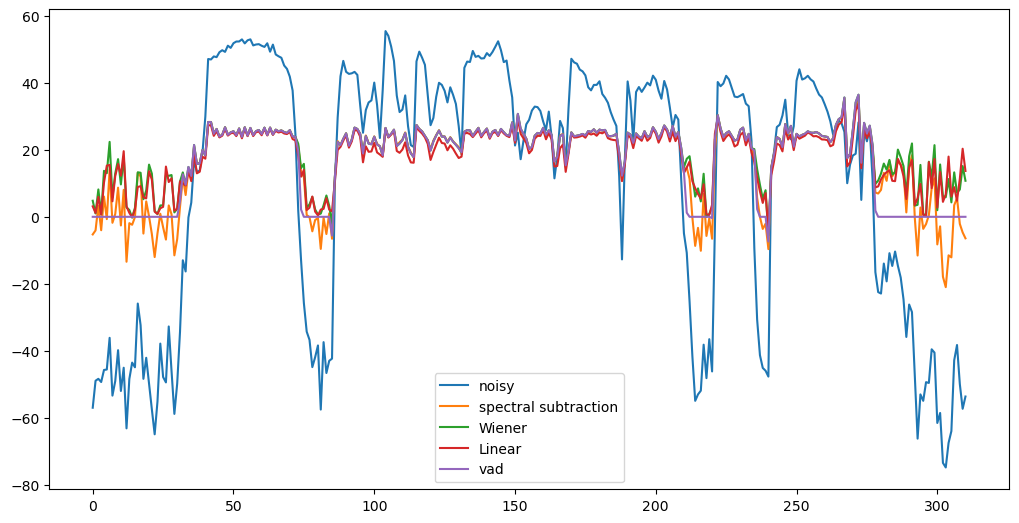

In [38]:
## Plotting and visualization
plt.figure()
fig, axes = plt.subplots(figsize=(12, 6))
fig.tight_layout()
#Plot the noisy signal and the segmental SNRs from the 4 methods. Let the x-axis denote frames and y-axis denote the SNR in dB

plt.plot(SNR_seg_noisy)
plt.plot(SNR_seg_ss)
plt.plot(SNR_seg_wie)
plt.plot(SNR_seg_linear)
plt.plot(SNR_seg_vad)
plt.legend(('noisy', 'spectral subtraction', 'Wiener', 'Linear', 'vad'))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)

<Figure size 640x480 with 0 Axes>

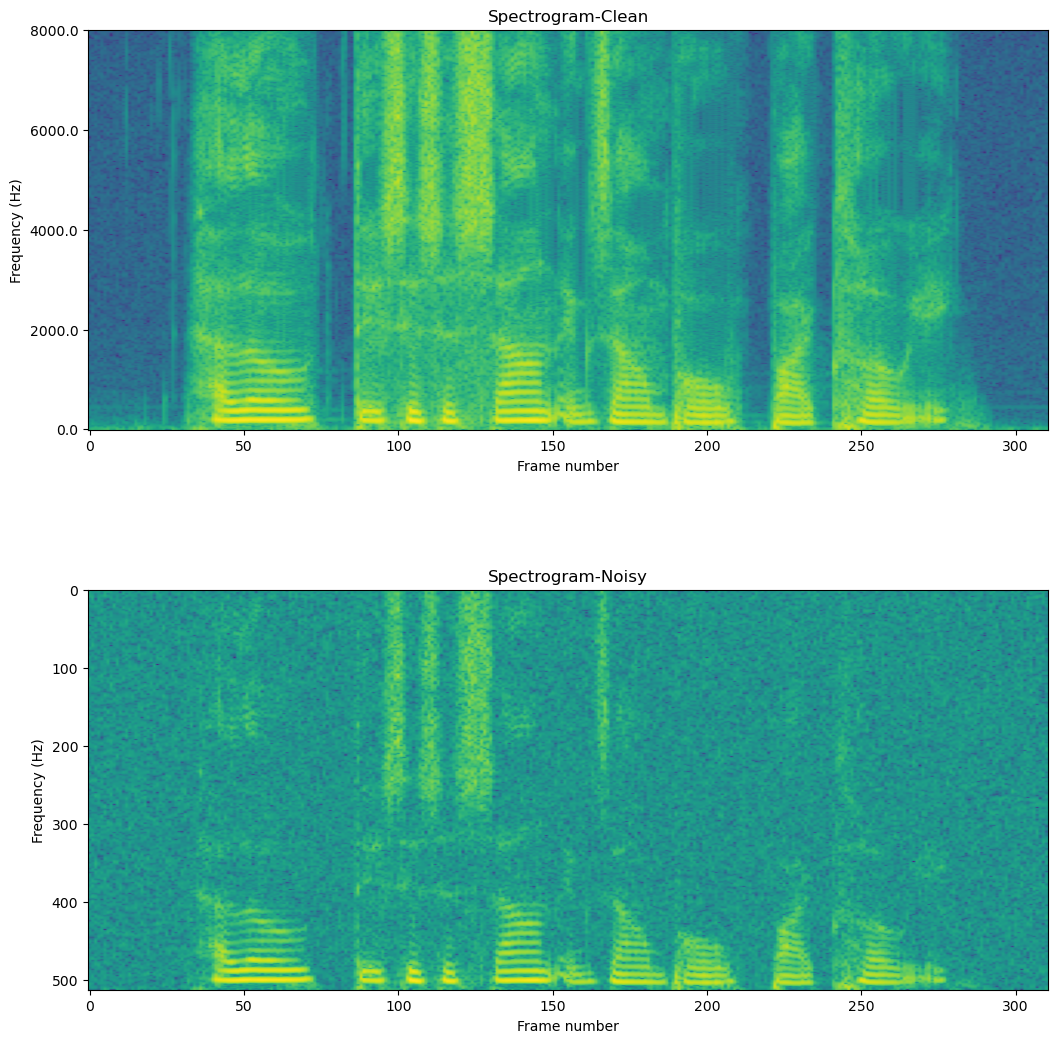

In [39]:
# Plot the spectrograms of the clean, noisy and the enhanced signals
# In this figure, plot the clean and noisy spectrograms
plt.figure()
fig, axes = plt.subplots(figsize=(12, 12))
fig.tight_layout()

eps = 1e-12 #Add before log10 to avoid zeros
Nfft = 1024

plt.subplot(2,1,1)
frame_matrix_fft = np.fft.rfft(frame_matrix_clean,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.yticks(np.linspace(0,Nfft/2,5),f_axis[ytickpos])
plt.title('Spectrogram-Clean')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

plt.subplot(2,1,2)
frame_matrix_fft = np.fft.rfft(frame_matrix,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.title('Spectrogram-Noisy')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)

<Figure size 640x480 with 0 Axes>

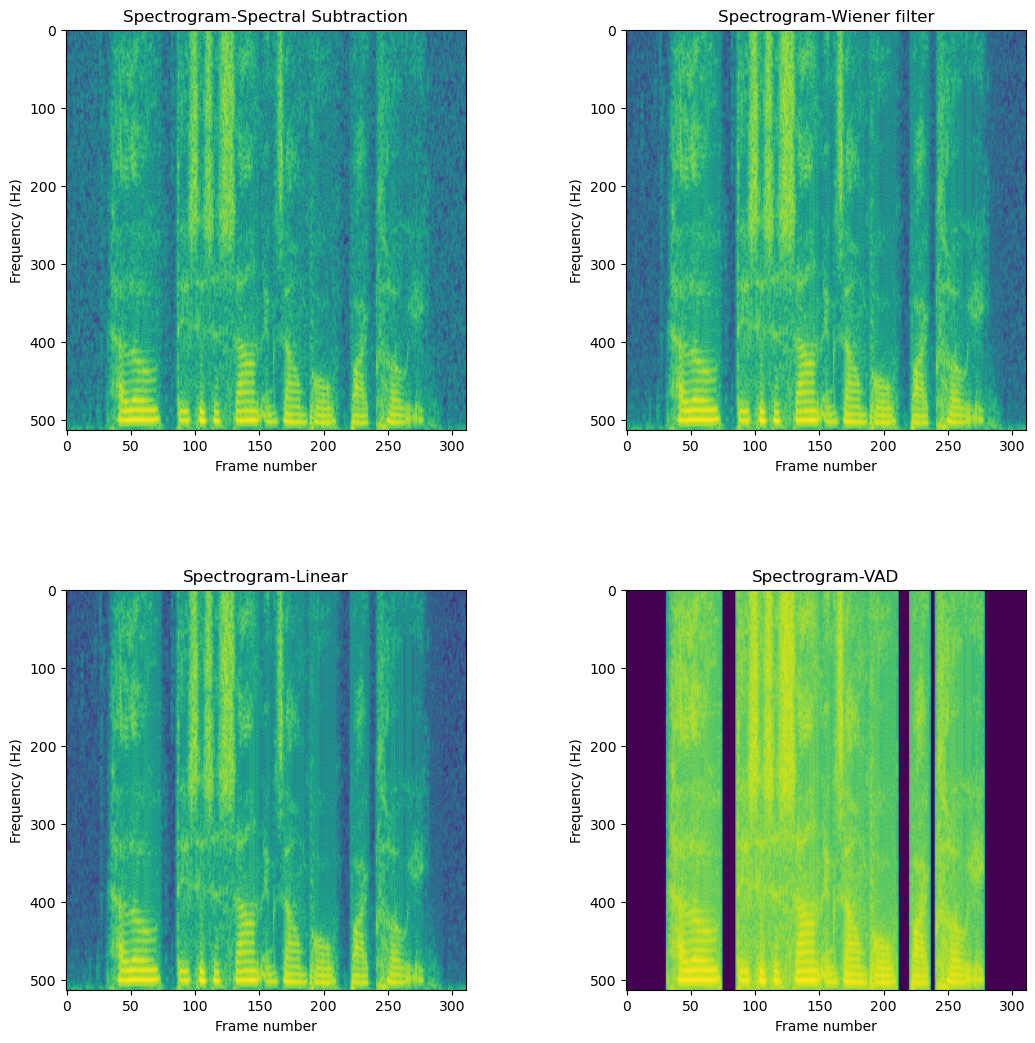

In [40]:
#In this figure, plot the spectrograms of all the 4 enhanced signals
plt.figure()
fig, axes = plt.subplots(figsize=(12, 12))
fig.tight_layout()

#Plot the enhanced signal with spectral subtraction
plt.subplot(2,2,1)
frame_matrix_fft = np.fft.rfft(frame_matrix_enhSS,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.title('Spectrogram-Spectral Subtraction')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

#Plot the enhanced signal with Wiener filter
plt.subplot(2,2,2)
frame_matrix_fft = np.fft.rfft(frame_matrix_enhWie,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.title('Spectrogram-Wiener filter')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

#Plot the enhanced signal with linear method
plt.subplot(2,2,3)
frame_matrix_fft = np.fft.rfft(frame_matrix_enhLin,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.title('Spectrogram-Linear')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

#Plot the enhanced signal with VAD method
plt.subplot(2,2,4)
frame_matrix_fft = np.fft.rfft(frame_matrix_enhvad,axis=0,n=Nfft)
frame_matrix_fft = 20*np.log10(np.absolute(np.flipud(frame_matrix_fft))+eps)
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft/2)+1),(Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0,Nfft/2,5)).astype(int)
plt.title('Spectrogram-VAD')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)